In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)

# Display basic information about the dataset
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Data Preprocessing
- Handling missing values
- Removing duplicates
- Encoding categorical variables
- Normalizing numerical variables
- Splitting into train, validation, and test sets

In [13]:
# 1. Handling Missing Values
data.dropna(inplace=True)

# 2. Removing Duplicates
data.drop_duplicates(inplace=True)

# 3. Encoding Categorical Variables
categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income"]
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_encoded = pd.DataFrame(encoder.fit_transform(data[categorical_cols]))
categorical_encoded.columns = encoder.get_feature_names_out(categorical_cols)

# Drop original categorical columns and replace with encoded ones
data = data.drop(columns=categorical_cols).reset_index(drop=True)
data = pd.concat([data, categorical_encoded], axis=1)

In [14]:
# 4. Outlier Detection & Treatment (Capping extreme values)
numeric_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.clip(data[col], lower_bound, upper_bound)

# 5. Normalization / Standardization
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [15]:
# 6. Train-Test Split
X = data.drop(columns=["hours-per-week"])  # Features
y = data["hours-per-week"]  # Target
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# 7. Optimized Hyperparameter Tuning on RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100],  # Reduced for faster execution
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

best_model = RandomForestRegressor(n_jobs=-1)  # Parallel processing for faster execution
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters and Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print Best Parameters and Scores
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R² Score: {r2}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 0.6742887426630902, MSE: 0.7354992405260499, RMSE: 0.8576125235361538, R² Score: 0.2653441407525049


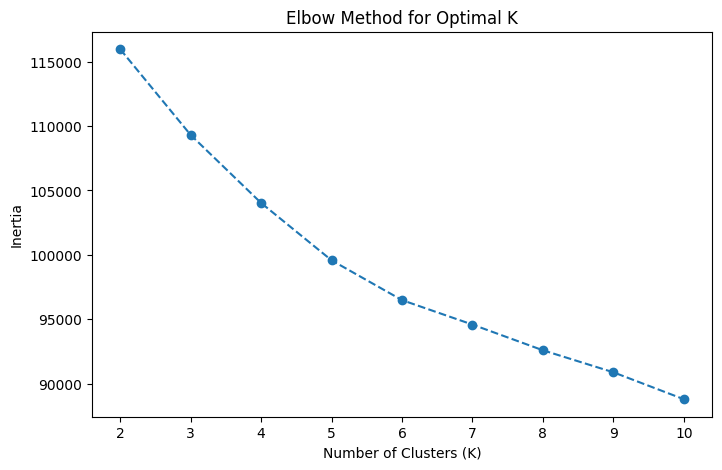

Silhouette Score for K-Means: 0.1454986539911635


In [17]:
#Task 4 Clustering

# Normalize features for clustering
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply the Elbow Method for Optimal K in K-Means
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# Train K-Means with optimal K
optimal_k = 4  # Choose based on elbow method graph
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Compute Silhouette Score
silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means: {silhouette_avg}")

# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

In [18]:
# Save Preprocessed Data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print("Model tuning, training, evaluation, and clustering complete. Results saved.")

Model tuning, training, evaluation, and clustering complete. Results saved.
